<a href="https://colab.research.google.com/github/Acabre21/machineLearning/blob/master/Problem3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Xception

I have replaced the VGG16 CNN with the Xeption CNN. I have modified the classifier by adding a dense layer with 128 neurons and a tanh activation function. I have also removed one of the previous dense layers as I think haveing three in my other CNN caused overfitting and high loss. This CNN now uses two dense layers. In addition to that, I have also unfrozen the conv2d_6 layer. 

Compared to the CNN in problem 3a, the loss and accuracy are very simliar. The subtraction of a dense layer did not have a huge impact on either result. 

Validation loss: 0.5675493478775024

Validation accuracy: 0.9760000109672546

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-22 00:22:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  64.8MB/s    in 1.0s    

2020-04-22 00:23:01 (64.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 27,415,337
Trainable params: 6,553,857
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 29s 292ms/step - loss: 0.4690 - acc: 0.7665 - val_loss: 0.0681 - val_acc: 0.9340
Epoch 2/30
100/100 [==============================] - 20s 198ms/step - loss: 0.3599 - acc: 0.8330 - val_loss: 0.1093 - val_acc: 0.9590
Epoch 3/30
100/100 [==============================] - 20s 198ms/step - loss: 0.3526 - acc: 0.8405 - val_loss: 0.1518 - val_acc: 0.9630
Epoch 4/30
100/100 [==============================] - 20s 196ms/step - loss: 0.3359 - acc: 0.8400 - val_loss: 0.0246 - val_acc: 0.9470
Epoch 5/30
100/100 [==============================] - 19s 194ms/step - loss: 0.3514 - acc: 0.8395 - val_loss: 0.0257 - val_acc: 0.9670
Epoch 6/30
100/100 [==============================] - 20s 195ms/step - loss: 0.2925 - acc: 0.8690 - val_loss: 0.0044 - val_acc: 0.9690
Epoch 7/30
100/100 [==============================] - 19s 194ms/step - loss: 0.3205 - acc: 0.8525 - val_lo

## Display curves of loss and accuracy during training

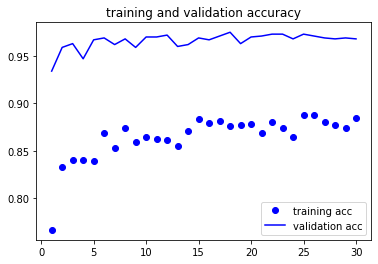

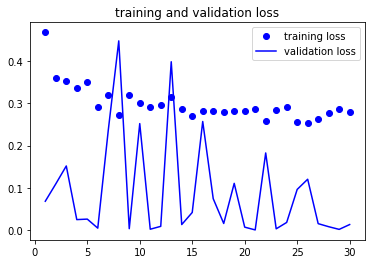

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  # unfreezing conv2d_6
  if layer.name == 'conv2d_6':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [16]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 37s 366ms/step - loss: 0.2481 - acc: 0.8905 - val_loss: 0.2367 - val_acc: 0.9560
Epoch 2/100
100/100 [==============================] - 28s 276ms/step - loss: 0.2312 - acc: 0.9090 - val_loss: 0.3100 - val_acc: 0.9320
Epoch 3/100
100/100 [==============================] - 28s 276ms/step - loss: 0.1941 - acc: 0.9190 - val_loss: 0.0603 - val_acc: 0.9500
Epoch 4/100
100/100 [==============================] - 28s 275ms/step - loss: 0.1815 - acc: 0.9230 - val_loss: 0.0311 - val_acc: 0.9460
Epoch 5/100
100/100 [==============================] - 28s 276ms/step - loss: 0.1783 - acc: 0.9225 - val_loss: 0.0416 - val_acc: 0.9490
Epoch 6/100
100/100 [==============================] - 28s 276ms/step - loss: 0.1629 - acc: 0.9360 - val_loss: 0.0539 - val_acc: 0.9530
Epoch 7/100
100/100 [==============================] - 28s 275ms/step - loss: 0.1619 - acc: 0.9405 - val_loss: 0.4991 - val_acc: 0.9510
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

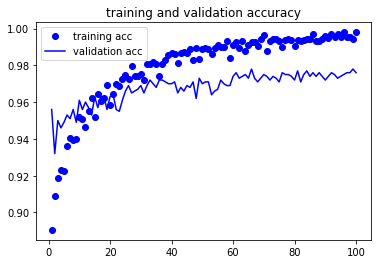

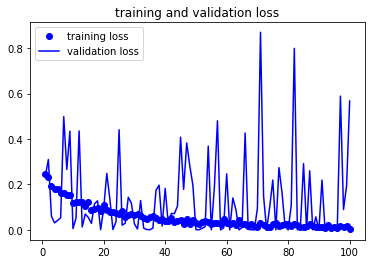

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [21]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.5675493478775024
Validation accuracy: 0.9760000109672546


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)